# Building a Convolutional Neural Network (CNN) to Help Good Seed Grocery Store Identify Underage Customers Attempting to Buy Alcohol

Good Seed Grocery Store is looking for an image recognition model that can help them avoid selling alcohol to underage customers. The goal of this project is to create a CNN which can aid them in this task. We will start by undergoing an exploratory data analysis to make sure the data is ready to be fed to the model. Then we will train, validate, and test a model comprised of a ResNet50 layer, a GlobalAveragePooling2D layer, and lastly a fully connected Dense layer without one output neuron that utilizes a relu activation function (relu is ideal for age prediction because it can only output positive values). We may make some subtle adjustements to this approach if we can see that they yield improvd performance. 

## Initialization

In [1]:
# Standard library imports
import os                              # File and path operations
import sys
from collections import Counter
try:
    from google.colab import files
except Exception as e:
    print('Not running script in google colab')
    
# Third-party imports
import numpy as np                     # Numerical computations
import pandas as pd                    # Data handling and analysis
import matplotlib.pyplot as plt       # Plotting
import seaborn as sns                  # Enhanced plotting
import tensorflow as tf                # TensorFlow for deep learning
from PIL import Image                 # Pillow for image file handling

Not running script in google colab


## Load Data

In [2]:
def in_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if in_colab():
    uploaded = files.upload()
    import pre_processing
else:
    from src import pre_processing

Not running in Colab or failed to load from Drive: No module named 'google.colab'
Loaded data from local project directory
    file_name  num_ratings  apparent_age_avg  apparent_age_std  real_age
0  000000.jpg           36          5.000000          1.146423         4
1  000001.jpg           63         20.079365          4.096819        18
2  000002.jpg           38         76.815789          6.133009        80
3  000003.jpg           38         55.657895          7.864653        50
4  000004.jpg           15         17.666667          3.457222        17
    file_name  num_ratings  apparent_age_avg  apparent_age_std  real_age
0  004113.jpg           26         26.230769          4.003076        29
1  004114.jpg           39         27.256410          4.552142        25
2  004115.jpg           14         23.142857          7.262730        37
3  004116.jpg           38         73.289474          6.472010        80
4  004117.jpg           21         20.142857          2.797958        25
 

In [3]:
# Assign train_ds, val_ds, and test_ds values from pre_processing.py to their namesakes as new variables. 
train_ds = pre_processing.train_ds
val_ds = pre_processing.val_ds
test_ds = pre_processing.test_ds

train_df = pre_processing.train_df
val_df = pre_processing.val_df
test_df = pre_processing.test_df

We are really only interested in the 'real_age' column. Therefore, the real_age column will be the focus of our exploratory data analysis.

In [4]:
# Instruct matplotlib to use seaborn presentation style
plt.style.use('seaborn-v0_8')
sns.set_theme(style='whitegrid')

In [5]:
# Concatinate lbabls data sets for global EDA analysis
eda_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

In [6]:
print(eda_df.info())
eda_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   file_name         7591 non-null   object 
 1   num_ratings       7591 non-null   int64  
 2   apparent_age_avg  7591 non-null   float64
 3   apparent_age_std  7591 non-null   float64
 4   real_age          7591 non-null   int64  
 5   file_path         7591 non-null   object 
dtypes: float64(2), int64(2), object(2)
memory usage: 356.0+ KB
None


,file_name,num_ratings,apparent_age_avg,apparent_age_std,real_age,file_path
0,000000.jpg,36,5.000000,1.146423,4,train\000000.jpg_face.jpg
1,000001.jpg,63,20.079365,4.096819,18,train\000001.jpg_face.jpg
2,000002.jpg,38,76.815789,6.133009,80,train\000002.jpg_face.jpg
3,000003.jpg,38,55.657895,7.864653,50,train\000003.jpg_face.jpg
4,000004.jpg,15,17.666667,3.457222,17,train\000004.jpg_face.jpg


In [7]:
eda_grouped_df = eda_df.groupby('real_age').sum().reset_index()

In [8]:
eda_grouped_df

,real_age,file_name,num_ratings,apparent_age_avg,apparent_age_std,file_path
0,1,000013.jpg000021.jpg000030.jpg000040.jpg000053...,5596,214.059117,87.062355,train\000013.jpg_face.jpgtrain\000021.jpg_face...
1,2,000012.jpg000036.jpg000079.jpg000312.jpg000362...,3325,219.550574,64.812195,train\000012.jpg_face.jpgtrain\000036.jpg_face...
2,3,000279.jpg000564.jpg000698.jpg000699.jpg000904...,867,96.128523,22.789798,train\000279.jpg_face.jpgtrain\000564.jpg_face...
3,4,000000.jpg000034.jpg000039.jpg000143.jpg000235...,3806,489.011245,123.565206,train\000000.jpg_face.jpgtrain\000034.jpg_face...
4,5,000017.jpg000024.jpg000068.jpg000130.jpg000360...,3309,487.728059,123.966205,train\000017.jpg_face.jpgtrain\000024.jpg_face...
...,...,...,...,...,...,...
92,94,003260.jpg005776.jpg005940.jpg006291.jpg007215...,167,419.980388,33.995215,train\003260.jpg_face.jpgtest\005776.jpg_face....
93,95,006121.jpg006336.jpg,74,159.877193,13.233117,test\006121.jpg_face.jpgtest\006336.jpg_face.jpg
94,96,006252.jpg006383.jpg,75,184.067568,7.713562,test\006252.jpg_face.jpgtest\006383.jpg_face.jpg
95,97,005806.jpg,37,89.405405,6.011376,test\005806.jpg_face.jpg


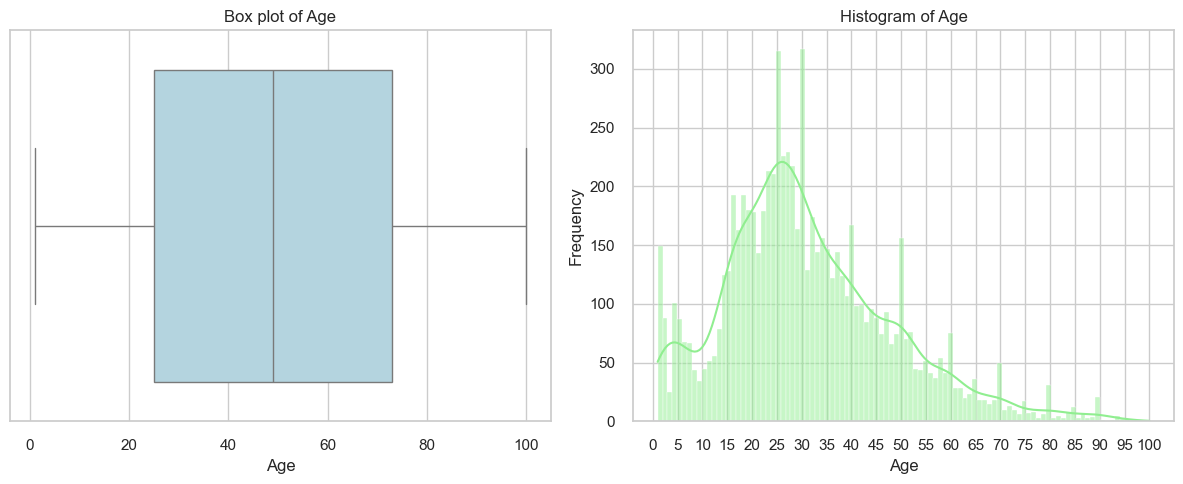

In [9]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)

sns.boxplot(data=eda_grouped_df, x='real_age', color='lightblue')
plt.title('Box plot of Age')
plt.xlabel('Age')

plt.subplot(1, 2, 2)
sns.histplot(data=eda_df, x='real_age', bins=100, kde=True, color='lightgreen')
plt.xticks(ticks=range(0, 101, 5))
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Our data set is a fair representation of the distribution of age in the United States. For example, as of 2020 the most numerous age range in the United States is 15-34 which roughly corresponds to what we see in our data set. The next most common age range in the United States after 15-34 is 55-59. This is not quite reflected in our data set. In our data the most common age after any between 15 and 34 is 40, and next is 50. Given that the paper associated with this data wsa published in 2017, it is fair to think that this data was taken in 2017 or a little bit before. If taken in 2016, depending on how the months align, this could put the age 50 peak at age 55 by some month in 2020. Even still, our data set is not in perfect alignment with that of the US population in 2020, and likely does not reflect the US age population in 2025.

Nevertheless, for the task at hand, our data set is appropriate. We are looking to predict the ages of people to decide if they are old enough to buy alcohol. Therefore, we want the most data points for people who are likely to buy aclohol when they are too young, and people who are old enough to buy alcohol but young looking enough so that their age appropriateness is not immediately obvious. The two most common ages in our data set are 25 and 30, with most of the next most common ages appearing between 16 and 30.

I got my information about the age distribution for the United States in 2020 here

Now let's get a look at the training, validation, and test sets separately to make sure their distributions for the real_age column are similar.

In [10]:
# Create list of names and DataFrames for easy plotting with for loops
names = ['Train', 'Validation', 'Test']
df_list = [train_df, val_df, test_df]

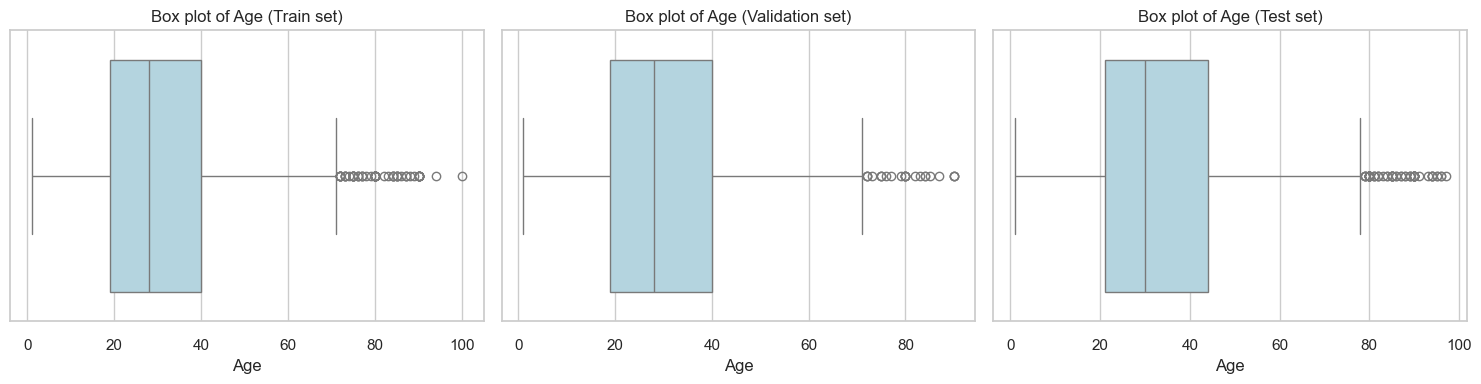

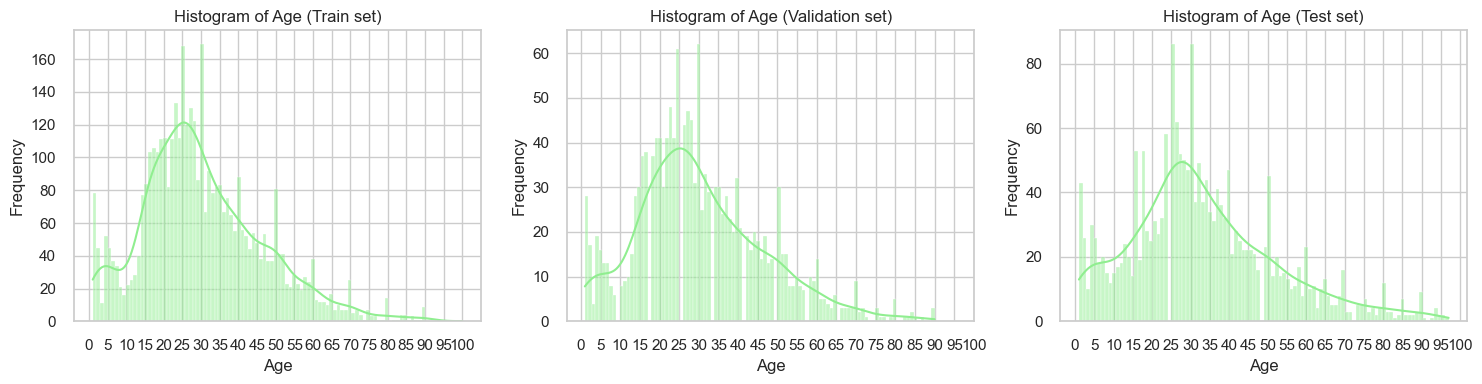

In [11]:
# Plot target variable for each set for piecewise EDA 
plt.figure(figsize=(15, 4))
for i, (df, name) in enumerate(zip(df_list, names)):
    plt.subplot(1, 3, i+1)
    sns.boxplot(data=df, x='real_age', color='lightblue')
    plt.title(f'Box plot of Age ({name} set)')
    plt.xlabel('Age')
plt.tight_layout()
plt.show

plt.figure(figsize=(15, 4))
for i, (df, name) in enumerate(zip(df_list, names)):
    plt.subplot(1, 3, i + 1)
    sns.histplot(data=df, x='real_age', bins=100, kde=True, color='lightgreen')
    plt.xticks(ticks=range(0, 101, 5))
    plt.title(f'Histogram of Age ({name} set)')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

The distribution of the target variable between our training set, validation set, and test set are very similar. Therefore, our model should generalize well to the validation and test sets. Let's get a look at the data set in full. Next we will print out some images to make sure there are no obvious misalignments between the labels and the images. 

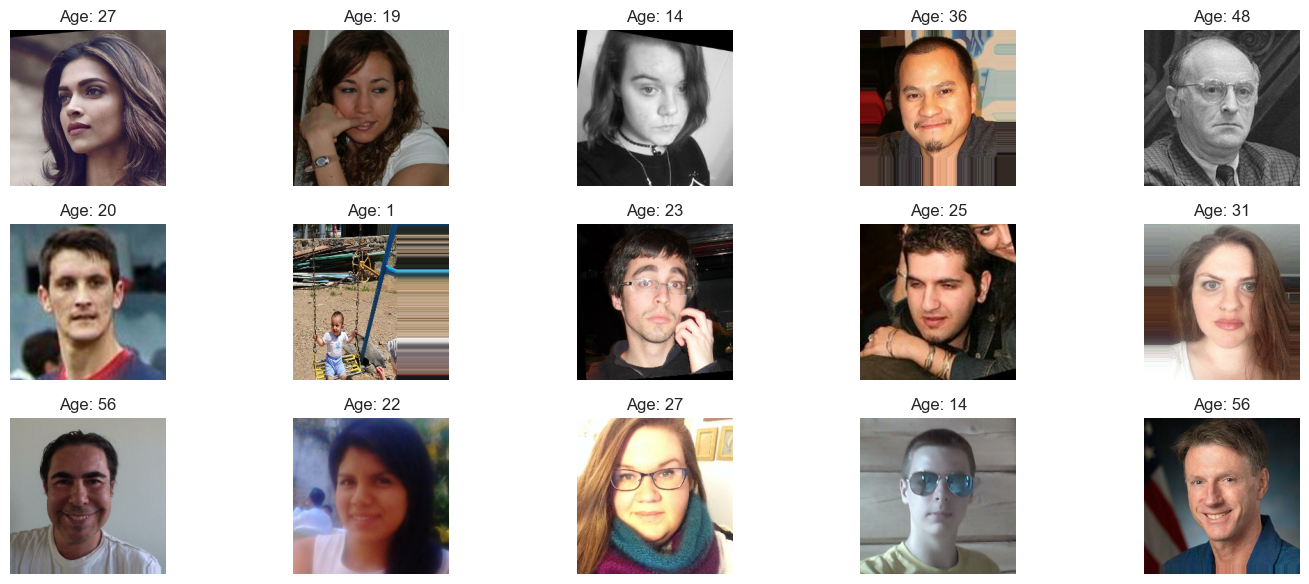

In [12]:
for images, labels in train_ds.take(1):
    # Select first 15 images and corresponding labels
    images = images[:15]
    labels = labels[:15]
    break

# Plot the images with corresponding labels
plt.figure(figsize=(15, 6))
for i in range(len(images)):
    plt.subplot(3, 5, i+1)
    plt.imshow(images[i].numpy()) 
    plt.title(f"Age: {int(labels[i])}")
    plt.axis('off')

plt.tight_layout()
plt.show()

The ages for our faces all appear to be appropriate, and we hae a variety of situations and lightings between images. There are no obvious biases presening themselves that would lead to overfitting. Therefore, we will leave the images as they are. Let's give the extremes of our data set a look just to make sure nothing is off with the age labels.

In [13]:
# Create variables containing images and lables for youngest 5
# faces and oldest 5 faces
youngest = eda_df.nsmallest(5, 'real_age')
oldest = eda_df.nlargest(5, 'real_age')

In [14]:
# Define function to plot youngest and oldest faces
def show_images(df, title):
    plt.figure(figsize=(15, 3))
    # itreate over each row for access to index and row contents
    for i, row in enumerate(df.itertuples()):
        
        img = tf.io.read_file(row.file_path)           # Extract file path
        img = tf.image.decode_jpeg(img, channels=3)    # Decode image found at file path
        img = tf.image.resize(img, [224, 224])/255.0   # rescale image 

        plt.subplot(1, len(df), i+1) # We use i+1 because subplot index starts at 1, and i starts at 0. 
        plt.imshow(img.numpy())
        plt.title(f"Age: {int(row.real_age)}")
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.plot()

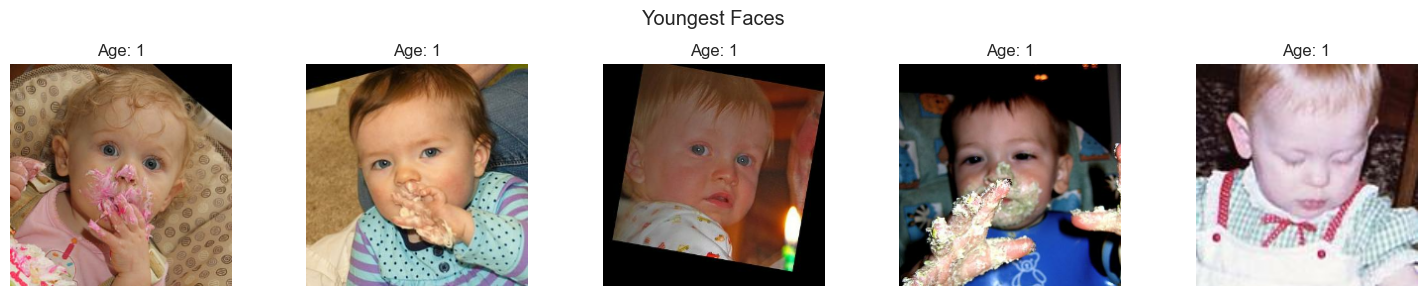

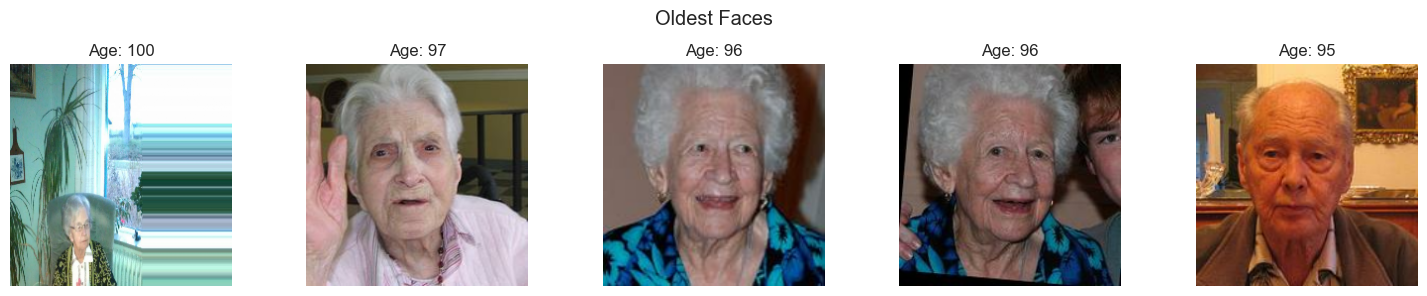

In [15]:
show_images(youngest, 'Youngest Faces')
show_images(oldest, 'Oldest Faces')

Okay, everything looks good here. Let's check the original image sizes to make sure the dimensions we rescaled to are appropriate. 

In [16]:
%%time
size_counter = Counter()
for path in eda_df['file_path']:
    try:
        with Image.open(path) as img:   # Use 'with' to presece resources
            # Count the number of images with a given size - Counter() works by using the tuple as a key
            size_counter[img.size] +=1
    except Exception as e:
        print("Error with {path}: {e}")

print(size_counter.most_common(10))

[((165, 165), 37), ((517, 517), 37), ((166, 166), 31), ((331, 331), 28), ((434, 434), 27), ((257, 257), 27), ((184, 184), 24), ((190, 190), 23), ((355, 355), 22), ((251, 251), 22)]
CPU times: total: 7.02 s
Wall time: 1min 50s


Great! All of our images are square, and there are no significant outliers. Therefore, our rescaling to 224, 224 is appropriate. Now we can move on to building and training our neural network. 